In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
# import utils and basic libraries
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from utils.preprocessing import gen_sub, bicubic
from utils.loss import l1_loss, psnr, ssim
from utils.prediction import ensemble, unensemble, shuffle_last_axis, predict_tensor, predict_tensor_permute, savePredictions, savePredictionsPermut
from utils.network import RAMS
from utils.training import Trainer
from skimage import io
from zipfile import ZipFile

C:\Users\tnguyen001\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\tnguyen001\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions o

In [ ]:
# gpu setting (we strongly discouraged to run this notebook without an available GPU)
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.random.set_seed(42)

In [28]:
#-------------
# General Settings
#-------------
PATH_DATASET = 'dataset_mq' # pre-processed dataset path
name_net = 'RAMS' # name of the network
LR_SIZE = 128 # pathces dimension
SCALE = 4 # upscale of the proba-v dataset is 3
HR_SIZE = LR_SIZE * SCALE # upscale of the dataset is 3
OVERLAP = 32 # overlap between pathces
CLEAN_PATH_PX = 0.85 # percentage of clean pixels to accept a patch
band = 'RED' # choose the band for the training
checkpoint_dir = f'ckpt/{band}_{name_net}' # weights path
log_dir = 'logs' # tensorboard logs path
submission_dir = 'result_mq/4' # submission dir
name_zip = 'submission_RAMS.zip'

In [29]:
#-------------
# Network Settings
#-------------
FILTERS = 32 # features map in the network
KERNEL_SIZE = 3 # convolutional kernel size dimension (either 3D and 2D)
CHANNELS = 9 # number of temporal steps
R = 8 # attention compression
N = 12 # number of residual feature attention blocks
lr = 1e-4 # learning rate (Nadam optimizer)
BATCH_SIZE = 32 # batch size
EPOCHS_N = 100 # number of epochs

<a id="loading"></a>
# 1.0 Dataset Loading

In [5]:
# load ESA test set (no ground truth)
X_test = np.load(os.path.join(PATH_DATASET, f'X_{band}_test.npy'))

In [6]:
print('X_test: ', X_test.shape)

X_test:  (1, 128, 128, 16)


<a id="network"></a>
# 2.0 Load the Network

In [30]:
# build rams network
rams_network = RAMS(scale=SCALE, filters=FILTERS, 
                 kernel_size=KERNEL_SIZE, channels=CHANNELS, r=R, N=N)

In [31]:
# load weights from checkpoint_dir
checkpoint = tf.train.Checkpoint(step=tf.Variable(0),
                                psnr=tf.Variable(1.0),
                                model=rams_network)

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

ValueError: Received incompatible tensor with shape (9,) when attempting to restore variable with shape (16,) and name weight_normalization_792/g:0.

<a id="proba"></a>
# 4.0 Predict Proba-V Test Set

In [123]:
# create submission folder
if not os.path.exists(submission_dir):
    os.mkdir(submission_dir)

## 4.1 RAMS prediction

In [27]:
# predict proba-v test set with RAMS
X_preds = []

for index in tqdm(range(X_test.shape[0])):
    X_preds.append(predict_tensor(rams_network, X_test[index:index+1]))

  0%|          | 0/1 [00:00<?, ?it/s]

ValueError: Input 0 of layer "RAMS" is incompatible with the layer: expected shape=(None, None, None, 9), found shape=(1, 128, 128, 16)

In [125]:
savePredictions(X_preds, band, submission_dir)

  0%|          | 0/1 [00:00<?, ?it/s]

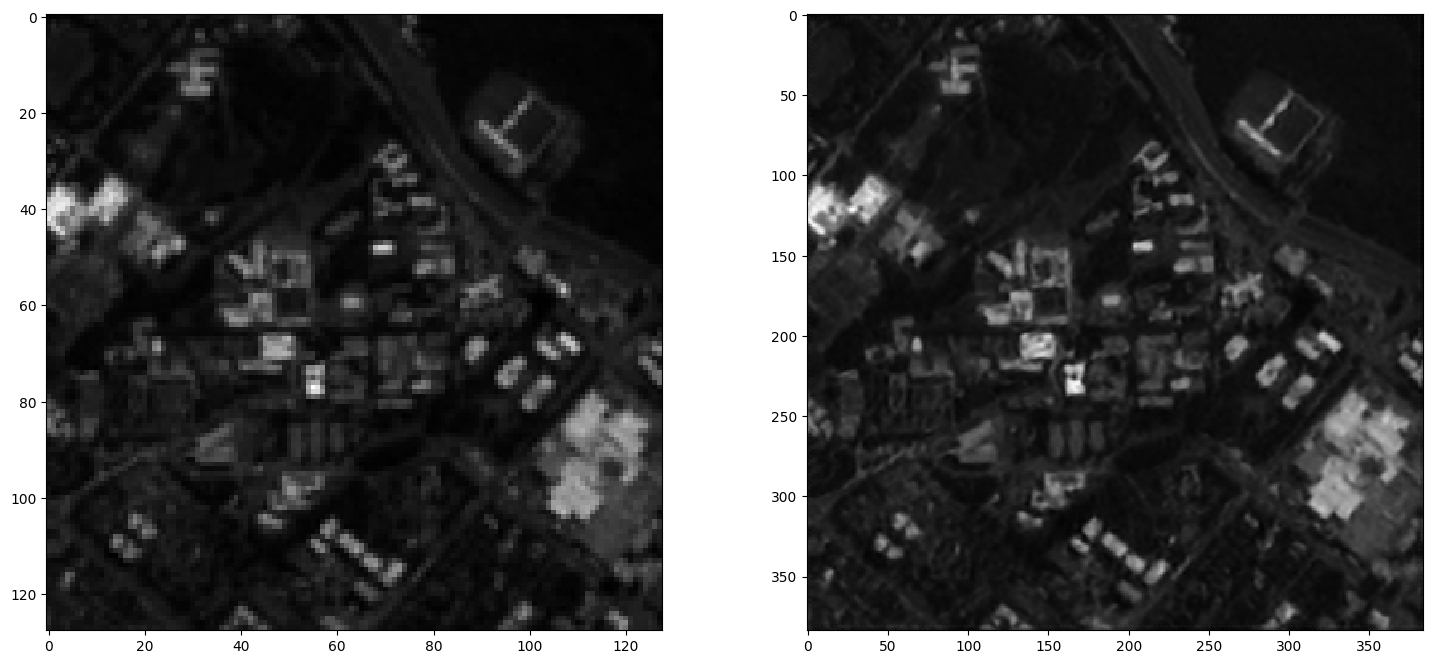

In [126]:
fig, ax = plt.subplots(1, 2, figsize=(18,8))

ax[0].imshow(X_test[0][...,1], cmap = 'gray', interpolation='None')
ax[1].imshow(X_preds[0][0,:,:,0], cmap='gray', interpolation='None')

plt.savefig('MQ_RED_band.png', bbox_inches='tight', dpi=200)

plt.show()

## 4.2 RAMS+ prediction

In [47]:
# predict proba-v test set with RAMS+
X_preds = []
n_permut = 20 # number of permutations

for index in tqdm(range(X_test.shape[0])):
    X_preds.append(predict_tensor_permute(rams_network, X_test[index], n_ens=n_permut))

  0%|          | 0/1 [00:00<?, ?it/s]

In [48]:
# save predictions in submission_dir
savePredictionsPermut(X_preds, band, submission_dir)

  0%|          | 0/1 [00:00<?, ?it/s]

## 4.3 Submission zip creation

In [ ]:
# zip creation
zf = ZipFile(name_zip, mode='w')
with tqdm(total=290, desc="Zipping images") as pbar:
    for i, img in enumerate(sorted(os.listdir(submission_dir))):
        zf.write(os.path.join(submission_dir, img), arcname=img)
        pbar.update(1)
zf.close()
print('Done!')